This notebook is designed to demonstrate how to produce plots for airborne EM (line data) and induction (point data) on a vertical section. We compare AEM conductvitiy inversions from a 1D-inversion (stored as netcdf file produced using geophys_utils) and 3D-inversions (stored as asci xyx file).

Neil Symington neil.symington@ga.gov.au

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import hydrogeol_utils.plotting_utils as plot_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import os, glob
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
import netCDF4
import math
import os
import gc
import matplotlib.pyplot as plt
from hydrogeol_utils.db_utils import makeCon, closeCon

In [2]:

cond_path = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\nc\HowardsEast_wb_inversion.nc"
wb_cond = netCDF4.Dataset(cond_path)



In [3]:
wb_cond['layer_top_depth']

<class 'netCDF4._netCDF4.Variable'>
float32 layer_top_depth(point, layer)
    long_name: Depth to the top of the layer
    units: m
    aseg_gdf_format: 30E9.3
unlimited dimensions: 
current shape = (72894, 30)
filling on, default _FillValue of 9.969209968386869e+36 used

In [4]:
# Open the LCI inversion

cond_path =r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\lci\HowardE_WB_MGA52.nc"
lci_cond = netCDF4.Dataset(cond_path)


In [5]:
# Create an instance of plots for gridding the data

wb_plots = plot_utils.ConductivitySectionPlot(wb_cond)
lci_plots = plot_utils.ConductivitySectionPlot(lci_cond)


# Define some key variables which we want to inteprolate

cond_vars = ['conductivity', 'data_residual', 'depth_of_investigation',
                               'easting', 'northing']

wb_plots.conductivity_variables = cond_vars
lci_plots.conductivity_variables = cond_vars


# Define the resolution of th sections
xres, yres = 10., 3.

In [8]:
lines = [114901]

In [19]:
lci_gridded_variables

NameError: name 'lci_gridded_variables' is not defined

In [15]:
# Grid the NBC and save it in memory
hdf5_wb_dir = r"C:\temp\hdf5_wb"

if not os.path.exists(hdf5_wb_dir):
    os.mkdir(hdf5_wb_dir)
    
hdf5_lci_dir = r"C:\temp\hdf5_lci"

if not os.path.exists(hdf5_lci_dir):
    os.mkdir(hdf5_lci_dir)



wb_gridded_variables = wb_plots.grid_variables(xres = xres, yres =yres, lines=lines, smoothed=False,
                                                 resampling_method = 'linear', save_hdf5 = True, return_dict = True,
                                                 hdf5_dir = hdf5_wb_dir)

LCI_gridded_variables = lci_plots.grid_variables(xres = xres, yres =yres, lines=lines, smoothed=False,
                                                 resampling_method = 'linear', save_hdf5 = True, return_dict = True,
                                                 hdf5_dir = hdf5_lci_dir)


In [16]:
outdir = r"C:\Users\PCUser\Desktop\NSC_data\AEM_viz_products\rj_sections"

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [17]:
line = lines[0]

Figure saved


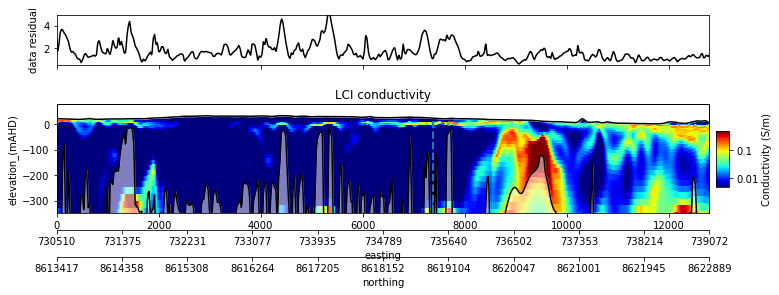

In [78]:
# Panel plotting for jrmcmc inversion

vex = 5.

max_depth = 350.

vmin, vmax = 0.005,0.5

# NOte that the vertical exaggeration and the max depth don't always play nicely
panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'LCI residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'LCI conductivity',
                                              'max_depth': max_depth, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': vmin, 'vmax': vmax,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':vex},
                             'height_ratio': 3}}

# Get ax_array length lists of the panel settings
panel_kwargs  = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')


height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                'height_ratio')


# Relative position of the colourbar
x0, y0, width, height = [1.01, 0., 0.02, 1.]

plot_settings = {'vertical_margin': 1.5,
                    'panel_vgap': 0.5, 'plot_width': 11.7 #A3 width
                }                        

# Close previous plots
plt.close()

# Intialise figure
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  height_ratios})


res1 = plot_utils.plot_single_line(ax_array[0], LCI_gridded_variables[line],
                                   'data_residual', panel_kwargs[0])

ax_array[1].set_title(panel_kwargs[0]['title'])

im1 = plot_utils.plot_grid(ax_array[1], LCI_gridded_variables[line], 'conductivity',
                   panel_kwargs[1])

ax_array[1].set_title(panel_kwargs[1]['title'])


# Format the figure to size it for the specified vertical exaggeration
plot_utils.format_panels(ax_array, panel_settings, plot_settings)

savefig = False
            

# Add colorbars
plot_utils.add_colourbar(fig, ax_array[1], im1, x0, y0, width, height, panel_kwargs[1])


ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot


east = LCI_gridded_variables[line]['easting']
nor = LCI_gridded_variables[line]['northing'] 

plot_utils.add_axis_coords('northing', nor, ax_array[-1], ax_pos[1], offset=-0.4)

plot_utils.add_axis_coords('easting', east, ax_array[-1], ax_pos[1], offset=-0.15)

# Plot a vertical line for the location of the rjmcmcm model

x, y = 735449, 8618876

# Find the distance along the line

ind = np.argmin(np.abs(x - LCI_gridded_variables[line]['easting']))

dist_along_line = LCI_gridded_variables[line]['grid_distances'][ind]

ymax = LCI_gridded_variables[line]['elevation'][ind]

ax_array[-1].axvline(x = dist_along_line, ymax = 0.85, linewidth = 2.,
                    linestyle = '--')

outfile = os.path.join(outdir, str(line) + "_LCI_section_rj_" + "E" + str(x) + "_N" + str(y) + ".png")

savefig = True

if savefig:
    print('Figure saved')
    plt.savefig(outfile, dpi=300)

plt.show()

In [56]:
nind = np.argmin(np.abs(ymax - LCI_gridded_variables[line]['grid_elevations']))

LCI_gridded_variables[line]['grid_elevations'][nind]

18.5

In [65]:
ax_array[-1].get_yscale()

'linear'

In [58]:
LCI_gridded_variables[line]['grid_elevations'].shape[0]

dir(ax_array[-1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',
 '_init_axis',
 '_label',
 '_layoutbox',
 '_left_title',
 '_make_twin_axes',
 '_

In [ ]:
# Panel plotting different inversions

vex = 5.

max_depth = 350.

vmin, vmax = 0.005,0.5

# NOte that the vertical exaggeration and the max depth don't always play nicely
panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'wb residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  'panel_2': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'LCI residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'wb conductivity',
                                              'max_depth': max_depth, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': vmin, 'vmax': vmax,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':vex},
                             'height_ratio': 3},
                  
                 'panel_4': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'LCI conductivity',
                                              'max_depth': max_depth, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': vmin, 'vmax': vmax,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':vex},
                             'height_ratio': 3}}

# Get ax_array length lists of the panel settings
panel_kwargs  = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')


height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                'height_ratio')


# Relative position of the colourbar
x0, y0, width, height = [1.01, 0., 0.02, 1.]

plot_settings = {'vertical_margin': 1.,
                    'panel_vgap': 0.5, 'plot_width': 11.7 #A3 width
                }                        

# Close previous plots
plt.close()

# Intialise figure
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  height_ratios})

res1 = plot_utils.plot_single_line(ax_array[0], wb_gridded_variables[line],
                                   'data_residual', panel_kwargs[0])

ax_array[0].set_title(panel_kwargs[0]['title'])

res2 = plot_utils.plot_single_line(ax_array[1], LCI_gridded_variables[line],
                                   'data_residual', panel_kwargs[1])

ax_array[1].set_title(panel_kwargs[1]['title'])

im1 = plot_utils.plot_grid(ax_array[2], wb_gridded_variables[line], 'conductivity',
                   panel_kwargs[2])

ax_array[2].set_title(panel_kwargs[2]['title'])


im2 = plot_utils.plot_grid(ax_array[3], LCI_gridded_variables[line], 'conductivity',
                    panel_kwargs[3])

ax_array[3].set_title(panel_kwargs[3]['title'])

# Find the minimum grid distance:
if LCI_gridded_variables[line]['grid_distances'][-1] > wb_gridded_variables[line]['grid_distances'][-1]:
    
    xmin = wb_gridded_variables[line]['grid_distances'][-1]
    east = wb_gridded_variables[line]['easting']
    nor = wb_gridded_variables[line]['northing']

else:
    xmin = LCI_gridded_variables[line]['grid_distances'][-1]
    east = LCI_gridded_variables[line]['easting']
    nor = LCI_gridded_variables[line]['northing'] 
    


ax_array[3].set_xlim(0,xmin)

#ax_array[3].set_xlim(20000,25000)

# Format the figure to size it for the specified vertical exaggeration
plot_utils.format_panels(ax_array, panel_settings, plot_settings)

savefig = False
            

# Add colorbars
plot_utils.add_colourbar(fig, ax_array[2], im1, x0, y0, width, height, panel_kwargs[2])

plot_utils.add_colourbar(fig, ax_array[3], im2, x0, y0, width, height, panel_kwargs[3])

ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

plot_utils.add_axis_coords('northing', nor, ax_array[-1], ax_pos[3], offset=-0.4)

plot_utils.add_axis_coords('easting', east, ax_array[-1], ax_pos[3], offset=-0.15)

    
outfile = os.path.join(outdir, str(line) + "_LCI_wb_comparison_plot_log.png")

savefig = True

if savefig:
    print('Figure saved')
    plt.savefig(outfile, dpi=300)

plt.show()